# Analyze FastML ASR sequences and finalize list for synthesis and testing 

For results presented in Fig 2c

In [1]:
!pip install biopython

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import pickle

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils

import A009_common

%reload_ext autoreload
%autoreload 2

In [3]:
fasta_read = A009_common.fasta_read

In [4]:
parent_names, parent_seqs = fasta_read(
    '20181110_filtered_FPBase_Aequorea_FPs_candidates_for_synthesis_alignment_training_homologs_only.fasta')

n11_names, n11_seqs = fasta_read('N11.10MostProbSeq.fasta')
n11_names = ['N11_'+n for n in n11_names]

n1_names, n1_seqs = fasta_read('N1.10MostProbSeq.fasta')
n1_names = ['N1_'+n for n in n1_names]


asr_seqs = n1_seqs + n11_seqs
asr_names = n1_names + n11_names

## Perform dim reduction on the sequences to visualize their relationship

In [5]:
parent_enc_seqs = utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots(parent_seqs)
n11_enc_seqs = utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots(n11_seqs)
n1_enc_seqs = utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots(n1_seqs)

av_enc = utils.encode_aa_seq_list_as_matrix_of_flattened_one_hots([constants.AVGFP_AA_SEQ])

In [6]:
dr = PCA(n_components=2).fit(parent_enc_seqs)

In [7]:
s_parents = dr.transform(parent_enc_seqs)
s_n11 = dr.transform(n11_enc_seqs)
s_n1 = dr.transform(n1_enc_seqs)

s_av = dr.transform(av_enc)

In [8]:
squash = lambda x: 1/(1 + np.exp(-3*x))

s_parents = squash(s_parents)
s_n11 = squash(s_n11)
s_n1 = squash(s_n1)
s_av = squash(s_av)

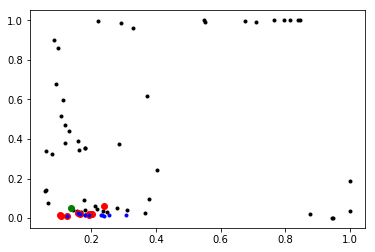

In [9]:
plt.plot(s_parents[:,0], s_parents[:,1], '.k')

plt.plot(s_n11[:,0], s_n11[:,1], 'or')
plt.plot(s_n1[:,0], s_n1[:,1], '.b')

plt.plot(s_av[:,0], s_av[:,1], 'og')
plt.show()

Looks like we have some sequences in the intersection. How big is that intersection?

In [10]:
set(n11_seqs).intersection(set(n1_seqs))

{'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFTYGVQCFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'}

## Edit distances wrt av and sfGFP?

In [11]:
print(utils.levenshtein_distance_matrix([constants.AVGFP_AA_SEQ], n11_seqs))

[[3. 4. 4. 2. 4. 4. 3. 3. 5. 2.]]


In [12]:
print(utils.levenshtein_distance_matrix([constants.AVGFP_AA_SEQ], n1_seqs))

[[4. 5. 5. 3. 5. 5. 5. 3. 5. 4.]]


## Common mutations

In [13]:
def build_edit_string_substitutions_only(seq, wt_seq): # from mlpe-gfp-pilot
    """Builds a 1-indexed edit string btw seq and wt_seq where there are assumed
    to be no indels.
    This function doesn't use nwalign and instead does a char by char comparison.
    Returns a String consisting of:
        * An edit string of the form e.g. 'SA8G:SR97W'
        * 'WT', if alignment is perfect match.
    """
    # Collect parts of the edit string then combine at the end.
    es_parts = []

    for i, wt_char in enumerate(wt_seq):
        if seq[i] != wt_char:
            one_indexed_pos = i + 1
            es_parts.append('{orig}{edit_pos}{new}'.format(
                    orig=wt_char,
                    edit_pos=one_indexed_pos,
                    new=seq[i]))

    if not es_parts:
        return 'WT'

    return es_parts

In [14]:
edits = []
for seq in asr_seqs:
    edits += build_edit_string_substitutions_only(seq, constants.AVGFP_AA_SEQ)
    
mutated_pos = [int(e[1:-1]) for e in edits]

In [15]:
mutated_pos

[64,
 65,
 72,
 80,
 64,
 65,
 72,
 79,
 80,
 64,
 65,
 72,
 80,
 203,
 64,
 72,
 80,
 64,
 65,
 68,
 72,
 80,
 64,
 65,
 72,
 80,
 203,
 64,
 65,
 68,
 72,
 80,
 64,
 65,
 80,
 64,
 65,
 72,
 80,
 203,
 64,
 65,
 72,
 80,
 64,
 72,
 80,
 64,
 65,
 72,
 80,
 64,
 65,
 72,
 80,
 64,
 80,
 64,
 72,
 80,
 203,
 64,
 65,
 72,
 80,
 64,
 65,
 80,
 64,
 65,
 80,
 64,
 65,
 72,
 80,
 203,
 72,
 80]

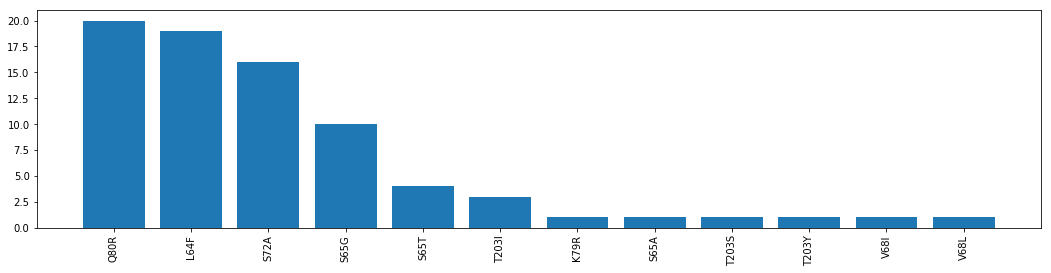

In [16]:
uv, uc = np.unique(edits, return_counts=True)

sidx = np.argsort(-uc)

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(uv)), uc[sidx])
plt.xticks(np.arange(len(uv)))
plt.gca().set_xticklabels(uv[sidx], rotation='vertical')
plt.xlim([-1, len(uv)])
plt.show()

In [17]:
uv

array(['K79R', 'L64F', 'Q80R', 'S65A', 'S65G', 'S65T', 'S72A', 'T203I',
       'T203S', 'T203Y', 'V68I', 'V68L'], dtype='<U5')

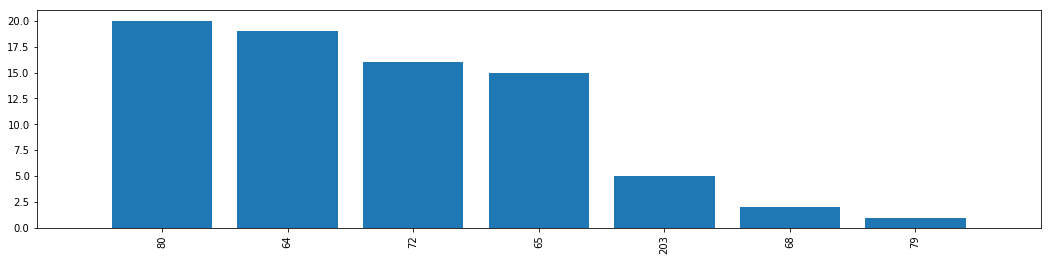

In [18]:
uv, uc = np.unique(mutated_pos, return_counts=True)

sidx = np.argsort(-uc)

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(uv)), uc[sidx])
plt.xticks(np.arange(len(uv)))
plt.gca().set_xticklabels(uv[sidx], rotation='vertical')
plt.xlim([-1, len(uv)])
plt.show()

## Prepare a non-redundant list of the ASR sequences

In [19]:
asr_names

['N1_1_-0.006831',
 'N1_2_-5.751725',
 'N1_3_-6.250951',
 'N1_4_-6.833884',
 'N1_5_-8.545060',
 'N1_6_-8.762511',
 'N1_7_-9.699390',
 'N1_8_-9.972933',
 'N1_9_-10.323871',
 'N1_10_-10.890914',
 'N11_1_-0.180372',
 'N11_2_-2.499699',
 'N11_3_-2.629019',
 'N11_4_-5.380227',
 'N11_5_-5.903730',
 'N11_6_-6.641509',
 'N11_7_-7.699554',
 'N11_8_-7.828874',
 'N11_9_-8.223057',
 'N11_10_-8.309947']

Unfortunately, the dictionary created in the cell below should have been created as an OrderedDict, as the key order for a vanilla dictionary when iterating over it is not reproducible. This causes the file output at the end of the notebook to output rows in a different order! Though the conclusions are the exact same, this ends up changing some of the downstream visuals. We're sorry we weren't more careful in this situation!

In [20]:
d = {}  
for i,s in enumerate(asr_seqs):
    if s not in d:
        d[s] = []
        
    d[s].append(asr_names[i])

In [21]:
for s in d:
    print(d[s])

['N11_7_-7.699554']
['N1_8_-9.972933', 'N11_8_-7.828874']
['N11_6_-6.641509']
['N1_2_-5.751725']
['N1_4_-6.833884', 'N11_1_-0.180372']
['N1_6_-8.762511']
['N1_1_-0.006831', 'N11_3_-2.629019']
['N11_4_-5.380227']
['N1_5_-8.545060']
['N11_10_-8.309947']
['N11_9_-8.223057']
['N1_9_-10.323871']
['N1_7_-9.699390']
['N1_10_-10.890914', 'N11_2_-2.499699']
['N1_3_-6.250951']
['N11_5_-5.903730']


Interestingly the rank ordering (by likelihood) of ASR seqs for N1 and N11 isnt highly correlated.

In [22]:
nr_asr_seqs = list(d.keys())
nr_asr_seq_names = ['__'.join(d[s]) for s in nr_asr_seqs]

In [23]:
for i,n in enumerate(nr_asr_seq_names):
    print(n)
    print(nr_asr_seqs[i])

N11_7_-7.699554
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
N1_8_-9.972933__N11_8_-7.828874
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
N11_6_-6.641509
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFAYGVQCFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
N1_2_-5.751725
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFARYPDHMRRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQ

In [24]:
df = pd.DataFrame()
df['id'] = nr_asr_seq_names
df['seq'] = nr_asr_seqs

df.head()

,id,seq
0,N11_7_-7.699554,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,N1_8_-9.972933__N11_8_-7.828874,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,N11_6_-6.641509,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,N1_2_-5.751725,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,N1_4_-6.833884__N11_1_-0.180372,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [25]:
df.to_csv('GFP_FastML_N1_N11_ASR_seqs.csv', index=False)